In [1]:
# user defined R installation
import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #path to your R installation
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import globalenv
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

from causaloptim_python import run_experiment, extract_prob_dict

import matplotlib.pyplot as plt
import seaborn as sns
import math




# Load R packages
#igraph = importr('igraph')
causaloptim = importr('causaloptim')
base = importr('base')

#### Data Generation

In [256]:
df_loaded = pd.read_pickle("synthetic_ate_dataset.pkl")
df_loaded.head()
df_loaded.ATE_true.describe()

count    1100.000000
mean        0.500307
std         0.259662
min         0.050771
25%         0.276058
50%         0.499937
75%         0.724690
max         0.949870
Name: ATE_true, dtype: float64

#### Iteration testing area

In [108]:
def simulate_deterministic_data_with_probabilistic_ate(
    n=5000,
    seed=None,
    intercept_X=-1.0,
    intercept_Y=-0.5,
    b_Z=1.5,
    b_U_X=1.2,
    b_X_Y=1.0,
    b_U_Y=1.5
):
    """
    Simulate deterministic (binary) data for causaloptim,
    but compute ATE from smooth logistic potential outcome probabilities.
    
    Returns:
        sim (dict): contains seed, coefficients, ATE_true, and arrays Z, U, X, Y
    """
    if seed is None:
        seed = np.random.randint(0, 1e6)
    np.random.seed(seed)
    # print(f"Seed: {seed}")

    # Binary variables
    Z = np.random.binomial(1, 0.5, size=n)
    U = np.random.binomial(1, 0.5, size=n)

    # Treatment assignment
    logit_X = intercept_X + b_Z * Z + b_U_X * U
    p_X = 1 / (1 + np.exp(-logit_X))
    X = np.random.binomial(1, p_X)

    # Deterministic outcome
    logit_Y = intercept_Y + b_X_Y * X + b_U_Y * U
    Y = (logit_Y > 0).astype(int)

    # Probabilistic potential outcomes
    logit_Y1 = intercept_Y + b_X_Y * 1 + b_U_Y * U
    logit_Y0 = intercept_Y + b_X_Y * 0 + b_U_Y * U
    p_Y1 = 1 / (1 + np.exp(-logit_Y1))
    p_Y0 = 1 / (1 + np.exp(-logit_Y0))
    ATE_true = np.mean(p_Y1 - p_Y0)

    return {
        'seed': seed,
        'intercept_X': intercept_X,
        'intercept_Y': intercept_Y,
        'b_Z': b_Z,
        'b_U_X': b_U_X,
        'b_X_Y': b_X_Y,
        'b_U_Y': b_U_Y,
        'ATE_true': ATE_true,
        'Z': Z,
        'U': U,
        'X': X,
        'Y': Y
    }

def simulate_with_rolling_coef(b_Z=1.5, b_U_X=1.2, b_U_Y=1.5, iterations=100): 
    results = []
    for i in np.arange(5, 10.5, 0.5):  # Use np.arange for 0.5 steps
        sim = simulate_deterministic_data_with_probabilistic_ate(
            b_X_Y=i,  # test impact
            b_Z=b_Z,
            intercept_Y=-5,
            seed=1234
        )

        # DataFrame for causaloptim
        df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})
        prob_dict = extract_prob_dict(df)

        # Define Model
        graph_str = "(Z -+ X, X -+ Y, Ur -+ X, Ur -+ Y)"
        leftside = [1, 0, 0, 0]
        latent   = [0, 0, 0, 1]
        nvals    = [2, 2, 2, 2]
        rlconnect = [0, 0, 0, 0]
        monotone = [0, 0, 0, 0]


        # Compute bounds
        bounds = run_experiment(
            graph_str, leftside, latent, nvals, rlconnect, monotone, prob_dict
        )
        bound_lower = float(bounds[0][0])
        bound_upper = float(bounds[1][0])

        bounds_valid = bound_lower <= sim['ATE_true'] <= bound_upper
        result = {
            'seed': sim['seed'],
            'b_Z': sim['b_Z'],
            'b_U_X': sim['b_U_X'],
            'b_X_Y': sim['b_X_Y'],
            'b_U_Y': sim['b_U_Y'],
            'ATE_true': sim['ATE_true'],
            'bound_lower': bound_lower,
            'bound_upper': bound_upper,
            'bounds_valid': bounds_valid
        }
        results.append(result)
    return results

### Simulate
df_results_array = []  # Array to store dataframes with corresponding values
for i in [1, 5]:  # b_U_X values
    df_results = pd.DataFrame(simulate_with_rolling_coef(b_Z=3, b_U_X=i, b_U_Y=i, iterations=100))
    df_results_array.append({'b_U_X': i, 'df_results': df_results})


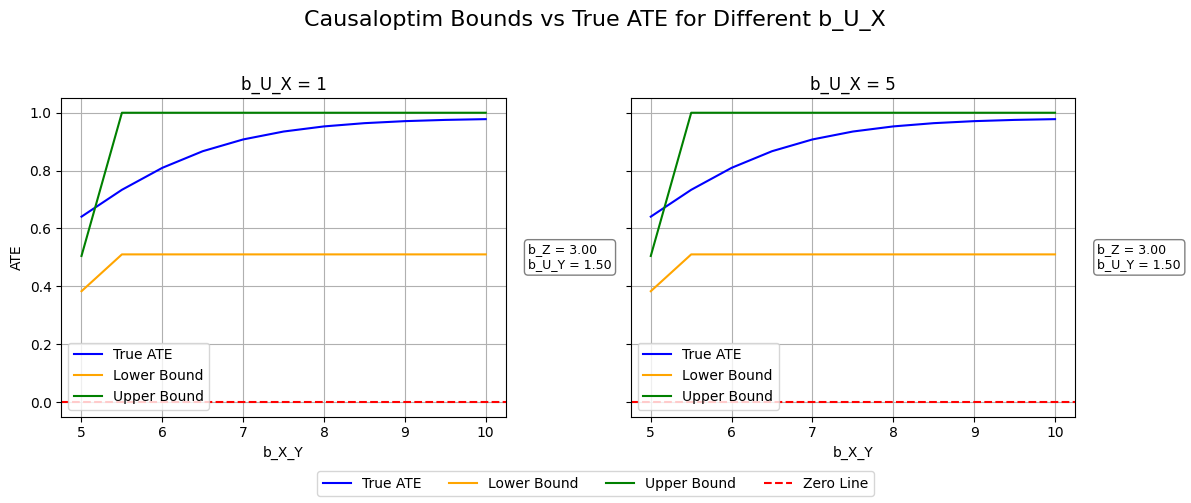

In [109]:

def plot_bounds_vs_ate(
    df_results_array,
    sweep_param='b_Z',
    x_param='b_X_Y',
    title_prefix='Causaloptim Bounds vs True ATE for Different',
    n_cols=2
):

    # Get unique values of the sweep parameter from the array
    sweep_values = [entry[sweep_param] for entry in df_results_array]
    n_plots = len(sweep_values)
    n_rows = math.ceil(n_plots / n_cols)

    # Set up subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), sharey=True)
    axes = axes.flatten()

    for ax, val in zip(axes, sweep_values):
        # Get the matching entry
        matching_entry = next((entry for entry in df_results_array if entry[sweep_param] == val), None)
        if matching_entry is None:
            continue

        df_results = matching_entry['df_results']
        first_row = df_results.iloc[0]

        # Extract coefficients (except the sweep and x param)
        coeffs = {
            k: v for k, v in {
                'b_Z': first_row['b_Z'],
                'b_U_X': first_row['b_U_X'],
                'b_U_Y': first_row['b_U_Y'],
                'b_X_Y': first_row['b_X_Y']
            }.items() if k not in [sweep_param, x_param]
        }

        coeff_text = "\n".join([f"{k} = {v:.2f}" for k, v in coeffs.items()])

        # Highlight invalid bounds
        invalid_bounds = df_results[df_results['bound_upper'] < df_results['bound_lower']]
        if not invalid_bounds.empty:
            ax.fill_between(
                invalid_bounds[x_param],
                invalid_bounds['bound_lower'],
                invalid_bounds['bound_upper'],
                color='red',
                alpha=0.15,
                label='Invalid Bounds'
            )

        # Plot lines
        sns.lineplot(data=df_results, x=x_param, y='ATE_true', label='True ATE', color='blue', ax=ax)
        sns.lineplot(data=df_results, x=x_param, y='bound_lower', label='Lower Bound', color='orange', ax=ax)
        sns.lineplot(data=df_results, x=x_param, y='bound_upper', label='Upper Bound', color='green', ax=ax)
        ax.axhline(0, color='red', linestyle='--', label='Zero Line')

        # Axis and title
        ax.set_title(f'{sweep_param} = {val}')
        ax.set_xlabel(x_param)
        ax.set_ylabel('ATE')
        ax.grid(True)

        # Add coefficient box
        ax.text(
            1.05, 0.5, coeff_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray')
        )

    # Add main legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4)

    plt.suptitle(f'{title_prefix} {sweep_param}', fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


plot_bounds_vs_ate(df_results_array, sweep_param='b_U_X', x_param='b_X_Y')


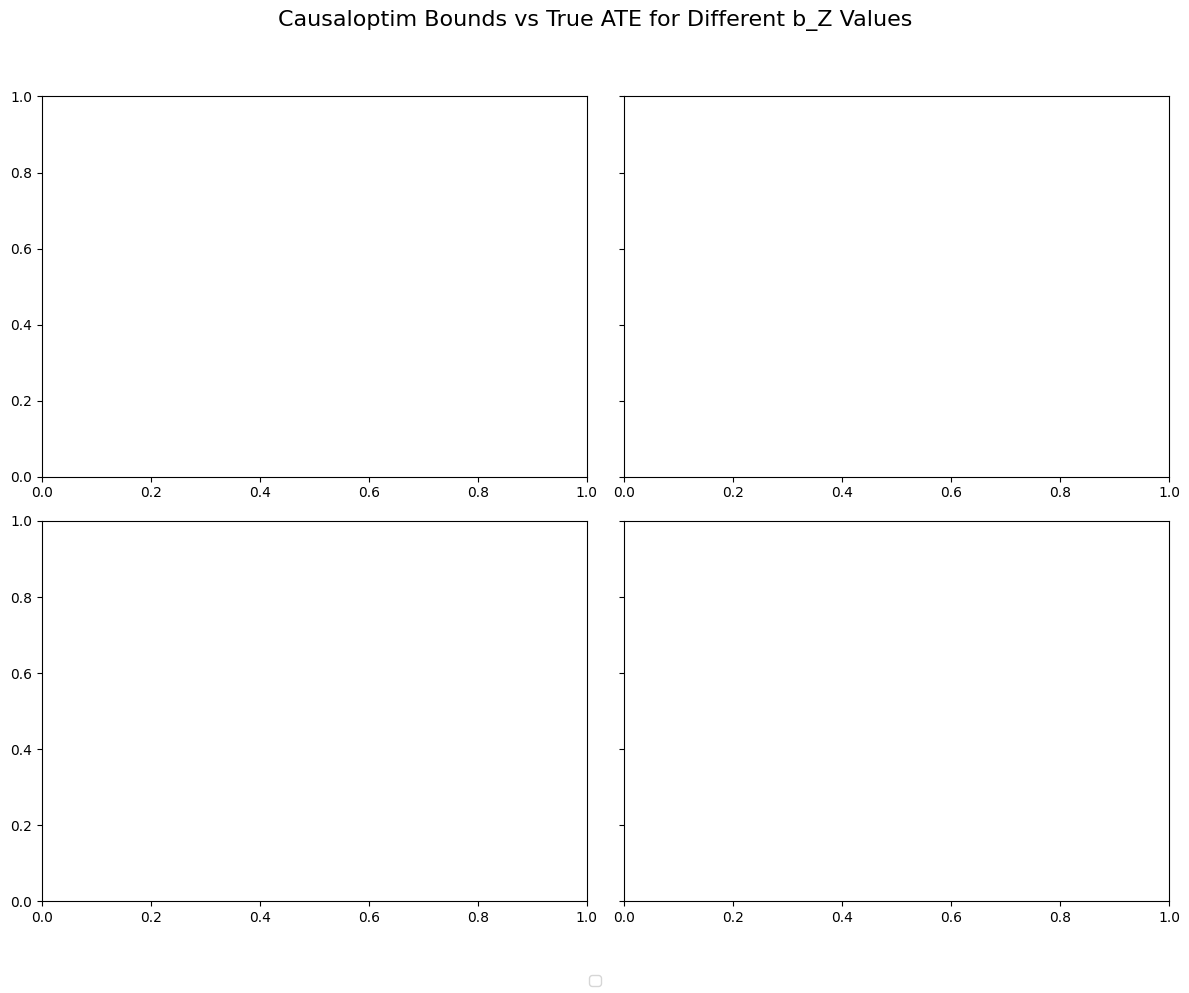

In [15]:
# Set the b_Z values you want to plot
b_Z_values_to_plot = [20, 30 , 50, 100]

# Determine number of rows and columns
n_plots = len(b_Z_values_to_plot)
n_cols = 2
n_rows = math.ceil(n_plots / n_cols)

# Set up the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), sharey=True)
axes = axes.flatten()  # flatten for easy indexing

for ax, b_Z in zip(axes, b_Z_values_to_plot):
    # Find the corresponding entry
    matching_entry = next((entry for entry in df_results_array if entry['b_Z'] == b_Z), None)
    if matching_entry is None:
        continue  # skip if this b_Z isn't in the data

    df_results = matching_entry['df_results']

    # Highlight invalid bounds
    invalid_bounds = df_results[df_results['bound_upper'] < df_results['bound_lower']]
    if not invalid_bounds.empty:
        ax.fill_between(
            invalid_bounds['b_X_Y'],
            invalid_bounds['bound_lower'],
            invalid_bounds['bound_upper'],
            color='red',
            alpha=0.15,
            label='Invalid Bounds'
        )

    sns.lineplot(data=df_results, x='b_X_Y', y='ATE_true', label='True ATE', color='blue', ax=ax)
    sns.lineplot(data=df_results, x='b_X_Y', y='bound_lower', label='Lower Bound', color='orange', ax=ax)
    sns.lineplot(data=df_results, x='b_X_Y', y='bound_upper', label='Upper Bound', color='green', ax=ax)
    ax.axhline(0, color='red', linestyle='--', label='Zero Line')
    ax.set_title(f'b_Z = {b_Z}')
    ax.set_xlabel('b_X_Y')
    ax.set_ylabel('ATE')
    ax.grid(True)

# Add a single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4)

plt.suptitle('Causaloptim Bounds vs True ATE for Different b_Z Values', fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # leave space for the legend and title
plt.show()



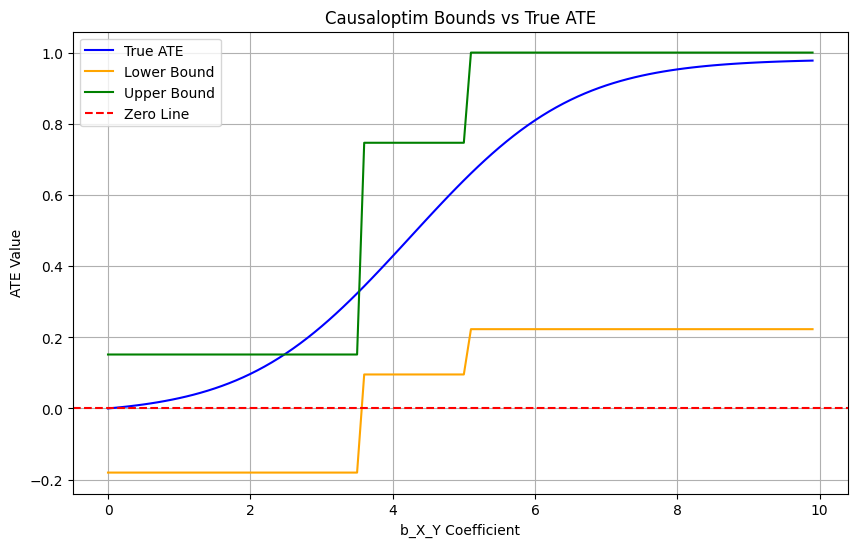

In [3]:
## Plot df_results as line chart, x axis should be b_X_Y, y axis should be ATE_true, bound_lower and bound_upper.
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='b_X_Y', y='ATE_true', label='True ATE', color='blue')
sns.lineplot(data=df_results, x='b_X_Y', y='bound_lower', label='Lower Bound', color='orange')
sns.lineplot(data=df_results, x='b_X_Y', y='bound_upper', label='Upper Bound', color='green')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.title('Causaloptim Bounds vs True ATE')
plt.xlabel('b_X_Y Coefficient')
plt.ylabel('ATE Value')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
def diagnose_simulation_seed(seed, n=5000, **kwargs):
    print(f"\n🔍 Diagnosing simulation with seed = {seed}")
    sim = simulate_deterministic_data_with_probabilistic_ate(n=n, seed=seed, **kwargs)
    df = pd.DataFrame({'Z': sim['Z'], 'U': sim['U'], 'X': sim['X'], 'Y': sim['Y']})

    # Compute distributions
    px_z = df.groupby("Z")["X"].mean()
    py_z = df.groupby("Z")["Y"].mean()
    py_x = df.groupby("X")["Y"].mean()

    print("\n📊 Empirical means:")
    print(f"P(X=1 | Z=0): {px_z[0]:.3f}   P(X=1 | Z=1): {px_z[1]:.3f}")
    print(f"P(Y=1 | Z=0): {py_z[0]:.3f}   P(Y=1 | Z=1): {py_z[1]:.3f}")
    print(f"P(Y=1 | X=0): {py_x[0]:.3f}   P(Y=1 | X=1): {py_x[1]:.3f}")

    print("\n🧮 ATE_true:", round(sim['ATE_true'], 4))
    print("\n📐 Coefficients:")
    for key in ['b_Z', 'b_U_X', 'b_X_Y', 'b_U_Y', 'intercept_X', 'intercept_Y']:
        print(f"  {key}: {sim[key]:.4f}")

    # Visual plots
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    sns.barplot(x=px_z.index, y=px_z.values, ax=axs[0])
    axs[0].set_title("P(X=1 | Z)")
    axs[0].set_ylim(0, 1)

    sns.barplot(x=py_z.index, y=py_z.values, ax=axs[1])
    axs[1].set_title("P(Y=1 | Z)")
    axs[1].set_ylim(0, 1)

    sns.barplot(x=py_x.index, y=py_x.values, ax=axs[2])
    axs[2].set_title("P(Y=1 | X)")
    axs[2].set_ylim(0, 1)

    plt.suptitle(f"Diagnostic Summary for Seed {seed}", fontsize=14)
    plt.tight_layout()
    plt.show()

    return sim, df


🔍 Diagnosing simulation with seed = 1234

📊 Empirical means:
P(X=1 | Z=0): 0.403   P(X=1 | Z=1): 0.736
P(Y=1 | Z=0): 0.642   P(Y=1 | Z=1): 0.811
P(Y=1 | X=0): 0.363   P(Y=1 | X=1): 1.000

🧮 ATE_true: 0.3307

📐 Coefficients:
  b_Z: 1.5000
  b_U_X: 1.2000
  b_X_Y: 2.0000
  b_U_Y: 1.5000
  intercept_X: -1.0000
  intercept_Y: -0.5000


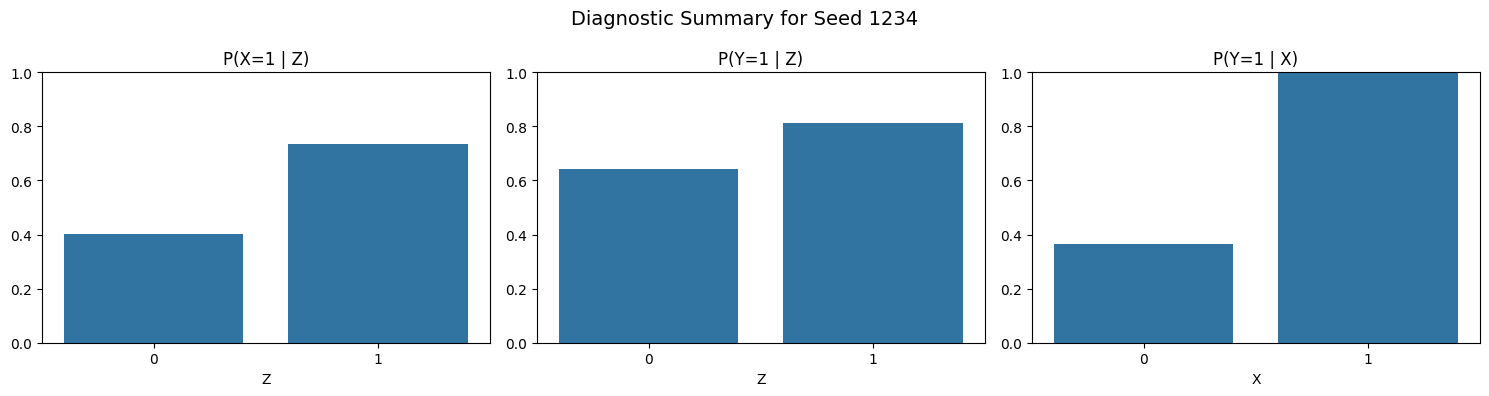

In [18]:
sim, df = diagnose_simulation_seed(seed=1234, b_X_Y=2) #out of bounds: 930512

#### 3-Dim Plotting
* plots the bound with on the y axis (instead of ATE)
* b_Z_X (instrument strength) on the x axis
* sweeps over  b_U_X (confounding strength

In [ ]:
def simulate_deterministic_data_with_probabilistic_ate(
    n=5000,
    seed=None,
    intercept_X=-1.0,
    intercept_Y=-0.5,
    b_Z=1.5,
    b_U_X=1.2,
    b_X_Y=1.0,
    b_U_Y=1.5
):
    """
    Simulate deterministic (binary) data for causaloptim,
    but compute ATE from smooth logistic potential outcome probabilities.
    
    Returns:
        sim (dict): contains seed, coefficients, ATE_true, and arrays Z, U, X, Y
    """
    if seed is None:
        seed = np.random.randint(0, 1e6)
    np.random.seed(seed)
    # print(f"Seed: {seed}")

    # Binary variables
    Z = np.random.binomial(1, 0.5, size=n)
    U = np.random.binomial(1, 0.5, size=n)

    # Treatment assignment
    logit_X = intercept_X + b_Z * Z + b_U_X * U
    p_X = 1 / (1 + np.exp(-logit_X))
    X = np.random.binomial(1, p_X)

    # Deterministic outcome
    logit_Y = intercept_Y + b_X_Y * X + b_U_Y * U
    Y = (logit_Y > 0).astype(int)

    # Probabilistic potential outcomes
    logit_Y1 = intercept_Y + b_X_Y * 1 + b_U_Y * U
    logit_Y0 = intercept_Y + b_X_Y * 0 + b_U_Y * U
    p_Y1 = 1 / (1 + np.exp(-logit_Y1))
    p_Y0 = 1 / (1 + np.exp(-logit_Y0))
    ATE_true = np.mean(p_Y1 - p_Y0)

    return {
        'seed': seed,
        'intercept_X': intercept_X,
        'intercept_Y': intercept_Y,
        'b_Z': b_Z,
        'b_U_X': b_U_X,
        'b_X_Y': b_X_Y,
        'b_U_Y': b_U_Y,
        'ATE_true': ATE_true,
        'Z': Z,
        'U': U,
        'X': X,
        'Y': Y
    }

In [ ]:
def simulate_with_rolling_b_Z_and_b_U_X(
    b_Z_values=None,
    b_U_X_values=None,
    b_X_Y_range=None,
    intercept_Y=-5,
    seed_base=1234
):
    """
    For each combination of b_Z (instrument strength) and b_U_X (confounding strength),
    simulate bounds across a range of b_X_Y (treatment effect strength),
    and store results for plotting.

    Returns:
        df_results_array: List of dicts with keys b_Z, b_U_X, df_results
    """
    if b_Z_values is None:
        b_Z_values = [0.1, 1, 5, 10, 50, 100]
    if b_U_X_values is None:
        b_U_X_values = [1, 5, 10, 100, 500]
    if b_X_Y_range is None:
        b_X_Y_range = np.arange(5, 10.5, 0.5)

    df_results_array = []

    for b_U_X in b_U_X_values:
        b_U_Y = b_U_X  # assume symmetric confounding
        for b_Z in b_Z_values:
            results = []

            for i, b_X_Y in enumerate(b_X_Y_range):
                sim = simulate_deterministic_data_with_probabilistic_ate(
                    b_X_Y=b_X_Y,
                    b_Z=b_Z,
                    b_U_X=b_U_X,
                    b_U_Y=b_U_Y,
                    intercept_Y=intercept_Y,
                    seed=seed_base + i
                )

                df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})
                prob_dict = extract_prob_dict(df)

                graph_str = "(Z -+ X, X -+ Y, Ur -+ X, Ur -+ Y)"
                leftside = [1, 0, 0, 0]
                latent = [0, 0, 0, 1]
                nvals = [2, 2, 2, 2]
                rlconnect = [0, 0, 0, 0]
                monotone = [0, 0, 0, 0]

                bounds = run_experiment(graph_str, leftside, latent, nvals, rlconnect, monotone, prob_dict)
                bound_lower = float(bounds[0][0])
                bound_upper = float(bounds[1][0])
                bounds_valid = bound_lower <= sim['ATE_true'] <= bound_upper

                results.append({
                    'b_Z': b_Z,
                    'b_U_X': b_U_X,
                    'b_U_Y': b_U_Y,
                    'b_X_Y': b_X_Y,
                    'ATE_true': sim['ATE_true'],
                    'bound_lower': bound_lower,
                    'bound_upper': bound_upper,
                    'bounds_valid': bounds_valid
                })

            df = pd.DataFrame(results)
            df_results_array.append({
                'b_Z': b_Z,
                'b_U_X': b_U_X,
                'df_results': df
            })

    return df_results_array



df_results_array = simulate_with_rolling_b_Z_and_b_U_X(
    b_Z_values=[0, 0.5, 1, 2, 8, 16],
    b_U_X_values=[0, 1, 5, 10],
)



SyntaxError: invalid syntax. Perhaps you forgot a comma? (1898971083.py, line 6)

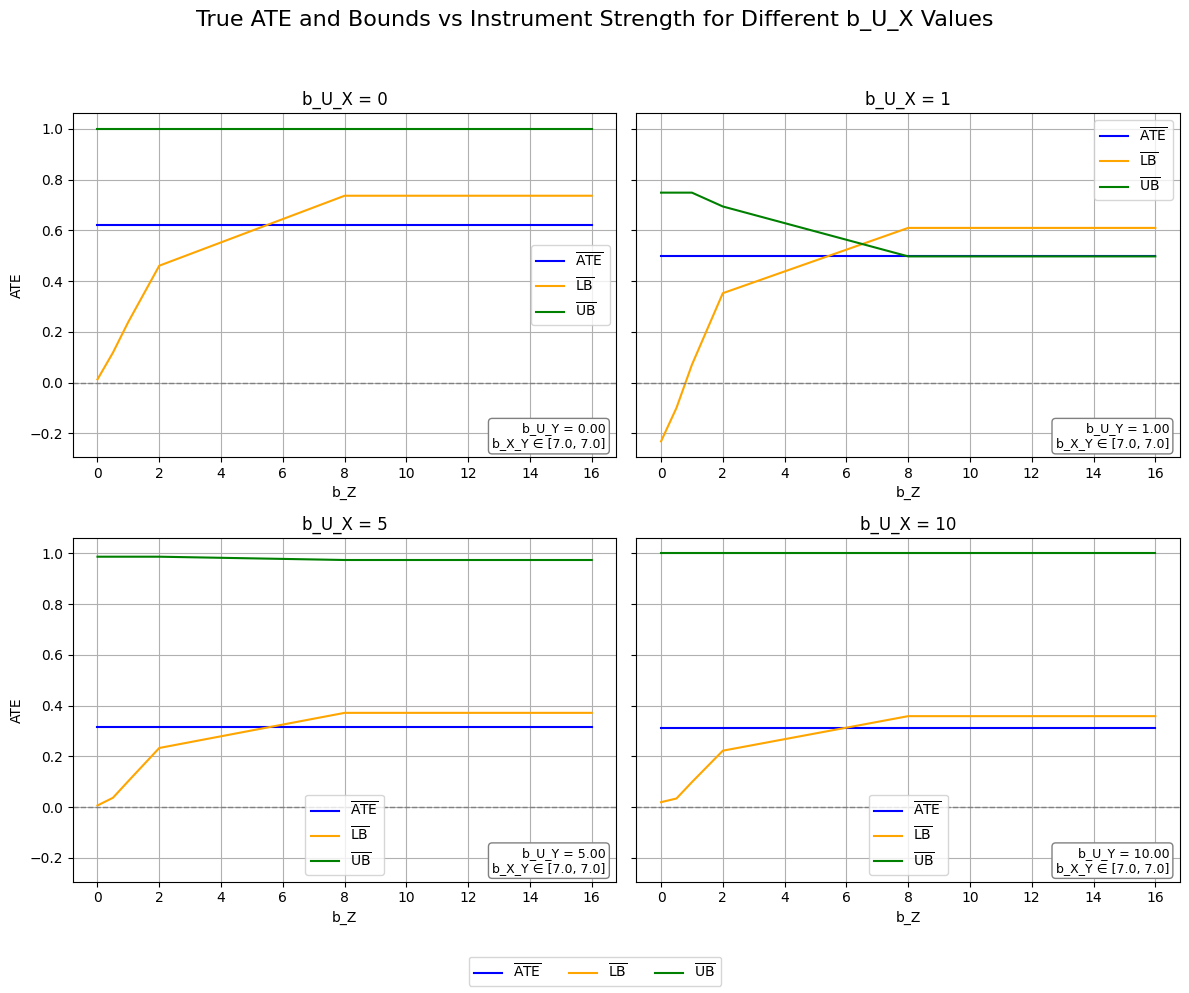

In [111]:
def plot_ate_and_bounds_vs_b_Z_for_each_b_U_X(
    df_results_array,
    agg_func='mean',
    n_cols=2,
    title_prefix='True ATE and Bounds vs Instrument Strength',
    x_param='b_Z',
    sweep_param='b_U_X'
):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math
    import pandas as pd

    # Extract unique sweep param values (e.g., b_U_X)
    unique_sweep_vals = sorted(set(entry[sweep_param] for entry in df_results_array))
    n_rows = math.ceil(len(unique_sweep_vals) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), sharey=True)
    axes = axes.flatten()

    for ax_idx, sweep_val in enumerate(unique_sweep_vals):
        ax = axes[ax_idx]

        # Get all entries for this sweep value
        matching_entries = [entry for entry in df_results_array if entry[sweep_param] == sweep_val]
        all_rows = []

        for entry in matching_entries:
            df = entry["df_results"].copy()
            all_rows.append(df)

        if not all_rows:
            continue

        df_concat = pd.concat(all_rows)

        # Aggregate values
        df_grouped = df_concat.groupby(x_param).agg({
            'ATE_true': agg_func,
            'bound_lower': agg_func,
            'bound_upper': agg_func
        }).reset_index()

        # Plot the curves
        sns.lineplot(data=df_grouped, x=x_param, y='ATE_true', label=r'$\overline{\mathrm{ATE}}$', color='blue', ax=ax)
        sns.lineplot(data=df_grouped, x=x_param, y='bound_lower', label=r'$\overline{\mathrm{LB}}$', color='orange', ax=ax)
        sns.lineplot(data=df_grouped, x=x_param, y='bound_upper', label=r'$\overline{\mathrm{UB}}$', color='green', ax=ax)

        ax.axhline(0, color='gray', linestyle='--', linewidth=1)
        ax.set_title(f'{sweep_param} = {sweep_val}')
        ax.set_xlabel(x_param)
        ax.set_ylabel('ATE')
        ax.grid(True)

        # --- Parameter box ---
        # Take first row of one matching entry as reference
        first = matching_entries[0]["df_results"].iloc[0]
        box_text = "\n".join([
            f"b_U_Y = {first['b_U_Y']:.2f}",
            f"b_X_Y ∈ [{df_concat['b_X_Y'].min():.1f}, {df_concat['b_X_Y'].max():.1f}]"
        ])
        ax.text(
            0.98, 0.02, box_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray')
        )

    # Turn off unused subplots
    for ax in axes[len(unique_sweep_vals):]:
        ax.axis('off')

    # Shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3)

    fig.suptitle(f'{title_prefix} for Different {sweep_param} Values', fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


plot_ate_and_bounds_vs_b_Z_for_each_b_U_X(df_results_array)